In [2]:
#!/usr/bin/env python
# coding: utf-8

# ## Brain Tumor Detection

# In[1]:


# Import necessary modules

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import cv2




In [3]:
# In[2]:
# path_to_zip_file = "/kaggle/input/brain-tumor/dataset"
# directory_to_extract_to = "/kaggle/input/mydataset"
# import zipfile
# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#   zip_ref.extractall(directory_to_extract_to)

# Load the images directories
path = r"/kaggle/input/brain-tumor/dataset"
print(os.listdir(path))

image_paths = list(paths.list_images(path))
print(len(image_paths))




['no', 'yes']
3000


In [4]:
# In[3]:


# 
images = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    images.append(image)
    labels.append(label)




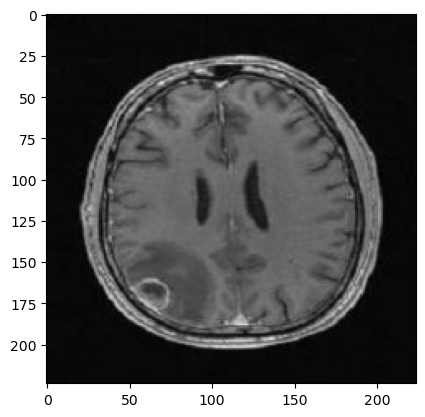

In [5]:
# In[4]:


# Plot an image
def plot_image(image):
    plt.imshow(image)

plot_image(images[0])




In [6]:
# In[5]:


# Convert into numpy arrays
images = np.array(images) / 255.0
labels = np.array(labels)




In [7]:
# In[6]:


# Perform One-hot encoding
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

print(labels[0])




[1. 0.]


In [8]:
# In[7]:


#Split the dataset
(train_X, test_X, train_Y, test_Y) = train_test_split(images, labels, test_size= 0.20, random_state= 42, stratify= labels)




In [9]:
# In[8]:


# Build the Image Data Generator
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)




In [10]:
# In[9]:


# Build the model
base_model = VGG16(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input
base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)




In [11]:
# In[10]:


# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False




In [12]:
# In[11]:


# Compile the model
model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')




In [13]:
# In[12]:


# Let's see the architecture summary of our model
model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
# In[13]:


batch_size = 64
train_steps = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size
epochs = 20




In [15]:
# In[14]:


# Fit the model
history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size= batch_size),
                              steps_per_epoch= train_steps,
                              validation_data = (test_X, test_Y),
                              validation_steps= validation_steps,
                              epochs= epochs)

model.save('/kaggle/working/brain_tumor_detection.h5')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == "__main__":


Epoch 1/20
37/37 [==============================] - 73s 1s/step - loss: 0.6870 - accuracy: 0.5963 - val_loss: 0.6106 - val_accuracy: 0.7983
Epoch 2/20
37/37 [==============================] - 31s 824ms/step - loss: 0.5885 - accuracy: 0.7243 - val_loss: 0.5332 - val_accuracy: 0.7900
Epoch 3/20
37/37 [==============================] - 31s 843ms/step - loss: 0.5252 - accuracy: 0.7603 - val_loss: 0.4822 - val_accuracy: 0.7967
Epoch 4/20
37/37 [==============================] - 31s 845ms/step - loss: 0.4856 - accuracy: 0.7821 - val_loss: 0.4273 - val_accuracy: 0.8233
Epoch 5/20
37/37 [==============================] - 31s 834ms/step - loss: 0.4392 - accuracy: 0.8082 - val_loss: 0.4024 - val_accuracy: 0.8217
Epoch 6/20
37/37 [==============================] - 31s 840ms/step - loss: 0.4114 - accuracy: 0.8228 - val_loss: 0.3726 - val_accuracy: 0.8433
Epoch 7/20
37/37 [==============================] - 31s 843ms/step - loss: 0.3952 - accuracy: 0.8395 - val_loss: 0.3453 - val_accuracy: 0.8600
Ep

In [16]:
# In[15]:


# Evaluate the model
predictions = model.predict(test_X, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)




10/10 [==============================] - 7s 758ms/step


In [17]:
# In[16]:


# Print Classification report and Confusion matrix
print(classification_report(actuals, predictions, target_names= label_binarizer.classes_))

cm = confusion_matrix(actuals, predictions)
print(cm)




              precision    recall  f1-score   support

          no       0.88      0.89      0.89       300
         yes       0.89      0.88      0.88       300

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.88       600
weighted avg       0.89      0.89      0.88       600

[[267  33]
 [ 36 264]]


In [23]:
# In[17]:


# Final accuracy of our model
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.4f}".format(accuracy))





Accuracy: 0.8850


1/1 [==============================] - 0s 162ms/step
p1 =  [[0.9782752  0.02172487]
 [0.48980644 0.5101936 ]]
p2 =  [0 1]


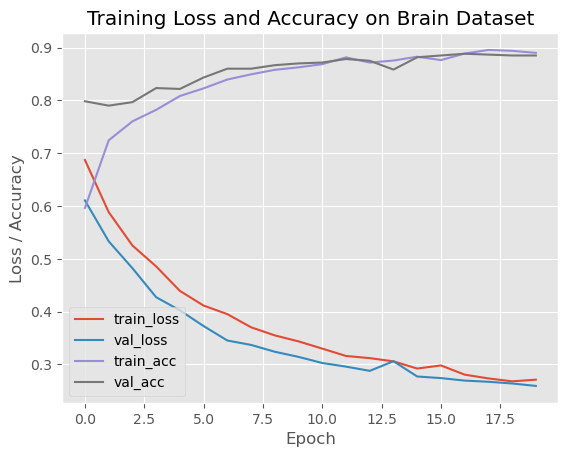

In [29]:
testing = []
loaded_model = keras.models.load_model('/kaggle/working/brain_tumor_detection.h5')
image = cv2.imread(r"/kaggle/input/brain-tumor/dataset/no/No19.jpg")
image = cv2.resize(image, (224, 224))
testing.append(image)
image = cv2.imread(r"/kaggle/input/brain-tumor/dataset/yes/y1050.jpg")
image = cv2.resize(image, (224, 224))
testing.append(image)
testing = np.array(testing) / 255.0
predictions = loaded_model.predict(testing, batch_size= batch_size)
print("p1 = ",predictions)
predictions = np.argmax(predictions, axis= 1)
print("p2 = ",predictions)
# In[18]:


# Plot the losses and accuracies
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label= "val_loss")

plt.plot(np.arange(0, N), history.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label= "val_acc")

plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.jpg")


# In[ ]: